In [240]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [241]:
import torchvision
from torchvision import datasets, models, transforms

In [242]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict

In [243]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
import Datasets.ModelData as md
from Transforms.ImageTransforms import *

In [244]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [245]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled

(True, 'GeForce GTX 960M', True)

In [246]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [247]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [248]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [249]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [250]:
def bbtohw(a): 
    """Bounding box to Height width.

    Args:
        param1 (arr): [xmin, ymin, xmax, ymax] where (xmin, ymin) 
            and (xmax, ymax) represent the top left and bottom 
            right corners of the bounding box

    Returns:
        arr: [xmin, ymin, width, height]

    """
    return [a[0],a[1],a[2]-a[0],a[3]-a[1]]

assert bbtohw([2, 5, 10, 20]) == [2, 5, 8, 15]

In [251]:
DATA_PATH = Path('C:/fastai/courses/dl2/data/road_damage_dataset')

In [252]:
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [253]:
examples = pd.read_csv(DATA_PATH/'train_labels.csv')
images = split(examples, 'filename')

In [254]:
def print_example(example, ax=None):
    im = ImageData.open_image(DATA_PATH/example.filename)
    if ax is not None:
        show_img(im, ax=ax)
    else:
        ax = show_img(im)
    for index, row in example.object.iterrows():
        bb = bbtohw([row['xmin'], row['ymin'], row['xmax'], row['ymax']]) # Bounding box converted to height width
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], row['class']) 

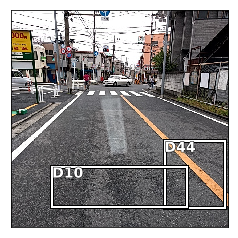

In [255]:
print_example(images[0])

In [256]:
im = ImageData.open_image(DATA_PATH/images[1].filename)

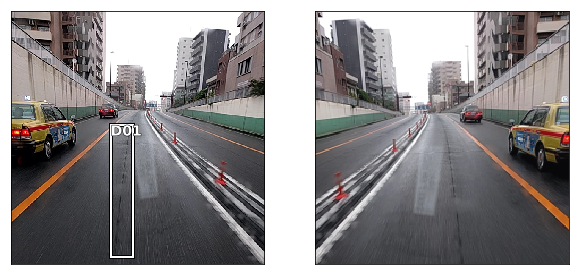

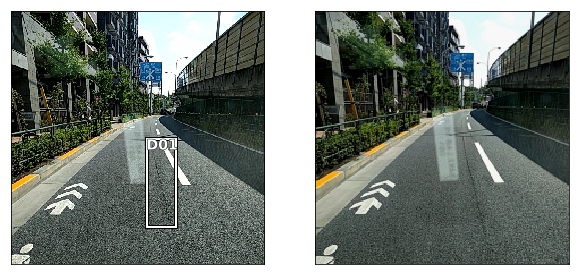

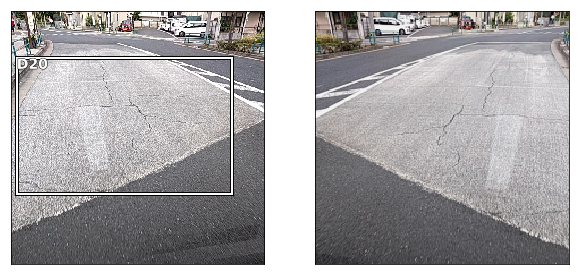

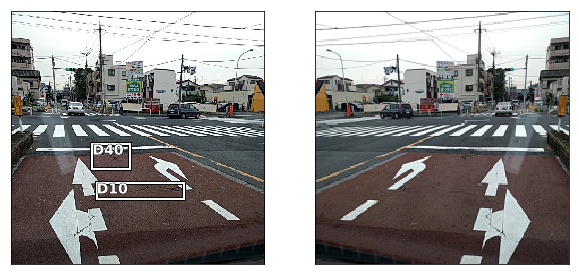

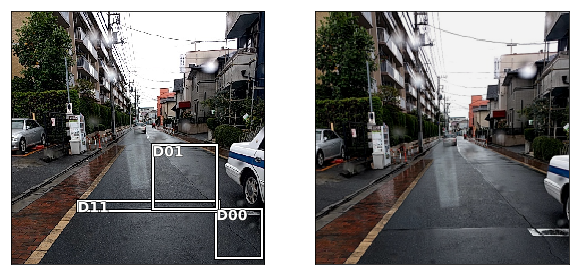

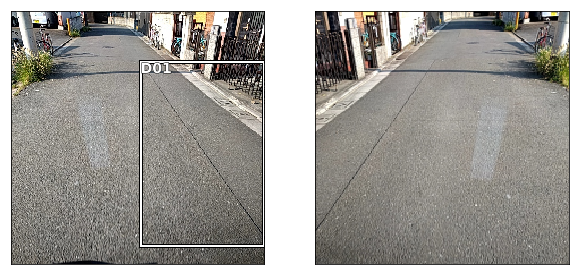

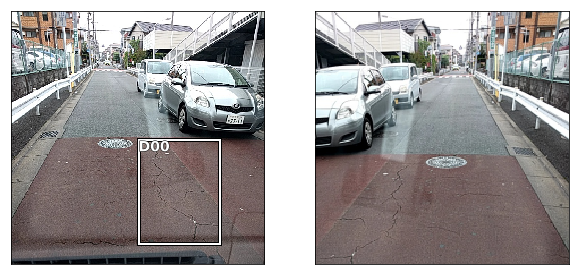

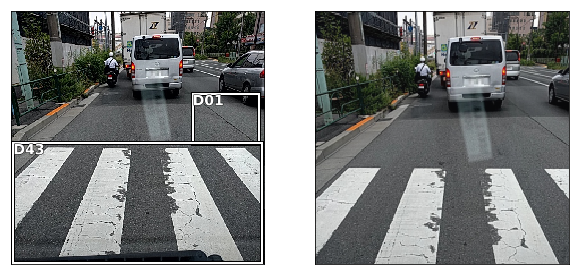

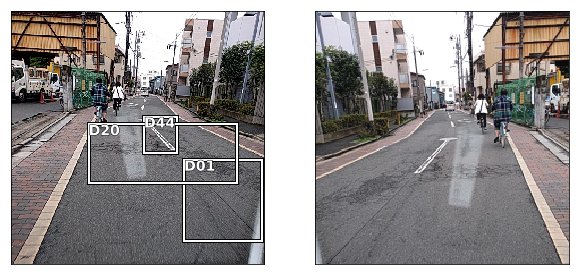

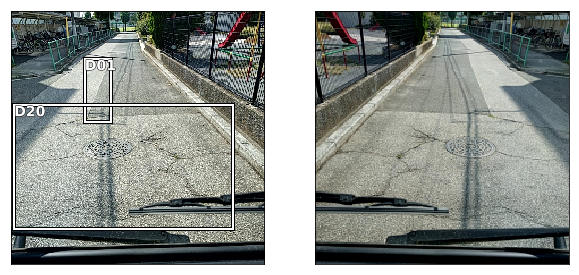

In [257]:
im_size = 224
test_tfms = TransformList([
        RandomScale(im_size, 1.2),
        RandomCrop(im_size),
        RandomLighting(0.05, 0.05),
        RandomHorizontalFlip()
])

for i in range(10, 20):
    f, ax = plt.subplots(1,2, figsize=(10, 10))
    print_example(images[i], ax[0])
    im = ImageData.open_image(DATA_PATH/images[i].filename) 
    ax[1].imshow(test_tfms(im, 0)[0])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)  

In [258]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [259]:
mc = [set([row['class'] for index, row in img.object.iterrows()]) for img in images]
mcs = [' '.join(label for label in labels) for labels in mc]
print(mc[0:4])
print(mcs[0:4])

[{'D10', 'D44'}, {'D01'}, {'D01'}, {'D01', 'D00'}]
['D10 D44', 'D01', 'D01', 'D01 D00']


In [260]:
df = pd.DataFrame({'filename': [img.filename for img in images], 'class': mcs}, columns=['filename','class'])
df.to_csv(MULTICLASS_CSV_PATH, index=False)

In [261]:
MULTIBB_CSV_PATH = DATA_PATH/'bb.csv'

In [262]:
print(images[0].object)

                                      filename  width  height class  xmin  \
9382  Adachi/JPEGImages/train_Adachi_00001.jpg    600     600   D44   424   
9383  Adachi/JPEGImages/train_Adachi_00001.jpg    600     600   D10   114   

      ymin  xmax  ymax  
9382   361   590   546  
9383   432   487   543  


In [263]:
mbb = [np.concatenate([[row['xmin'], row['ymin'], row['xmax'], row['ymax']] for index, row in img.object.iterrows()]) for img in images]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

In [264]:
mbbs

['424 361 590 546 114 432 487 543',
 '113 353 260 592 318 300 455 582',
 '474 344 598 493',
 '362 228 524 578 130 310 399 589',
 '88 381 167 455 84 282 326 336 272 356 485 537',
 '391 384 540 587 347 322 548 588 1 382 144 592',
 '16 325 183 466',
 '190 263 253 392 5 276 146 400',
 '146 288 266 476 363 301 594 532',
 '237 258 585 305 1 291 233 469',
 '236 269 289 583',
 '321 302 390 511',
 '14 111 523 434',
 '203 406 409 445 193 314 281 373',
 '486 469 593 585 158 450 493 474 335 318 487 468',
 '307 121 598 556',
 '302 306 494 552',
 '430 197 586 314 6 313 593 597',
 '410 352 595 545 315 250 394 336 184 268 536 408',
 '175 114 237 264 8 223 525 516',
 '150 312 478 344 452 438 600 545',
 '1 308 191 476 338 265 442 600',
 '437 467 582 591',
 '264 69 412 254',
 '345 232 420 475',
 '74 325 111 591',
 '514 483 600 577 23 277 109 502 103 311 194 432',
 '354 284 488 594',
 '392 455 598 524 104 381 359 599',
 '407 225 583 451 164 273 260 466',
 '330 336 594 577 305 387 391 469 10 400 93 596',
 

In [265]:
df = pd.DataFrame({'filename': [img.filename for img in images], 'bbox': mbbs}, columns=['filename','bbox'])
df.to_csv(MULTIBB_CSV_PATH, index=False)

In [266]:
df.head()

,filename,bbox
0,Adachi/JPEGImages/train_Adachi_00001.jpg,424 361 590 546 114 432 487 543
1,Adachi/JPEGImages/train_Adachi_00002.jpg,113 353 260 592 318 300 455 582
2,Adachi/JPEGImages/train_Adachi_00003.jpg,474 344 598 493
3,Adachi/JPEGImages/train_Adachi_00004.jpg,362 228 524 578 130 310 399 589
4,Adachi/JPEGImages/train_Adachi_00006.jpg,88 381 167 455 84 282 326 336 272 356 485 537


In [267]:
files = [str(DATA_PATH/img.filename) for img in images]

In [268]:
labels = [md.StructuredLabel([(np.array(bb.split(' ')).astype(np.float32), md.LabelType.BOUNDING_BOX), (cat, md.LabelType.CATEGORY)]) for bb, cat in zip(mbbs, mcs)]

In [269]:
print(labels[0])

[(array([424., 361., 590., 546., 114., 432., 487., 543.], dtype=float32), <LabelType.BOUNDING_BOX: 3>), ('D10 D44', <LabelType.CATEGORY: 1>)]


In [270]:
dataset = ImageData.ImageDataset(files, labels, test_tfms)

In [271]:
init_label = labels[0]
im, new_label, *_ = dataset[0]

[424. 361. 590. 546. 114. 432. 487. 543.]
LabelType.BOUNDING_BOX
D10 D44
LabelType.CATEGORY
[array([141., 141., 182., 182.], dtype=float32), array([0., 0., 0., 0.], dtype=float32)]
LabelType.BOUNDING_BOX


IndexError: list index out of range

In [ ]:
print(init_label)

In [ ]:
print(new_label)